pip install tensorflow \
pip install matplotlib \
pip install seaborn \
pip install pandas \
pip install numpy \
pip install scikit-learn \
pip install jinja2

In [3]:
import tensorflow as tf # importowanie wymaganych bibliotek
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector

In [6]:
data = pd.read_csv('C:/Users/lukiu/Desktop/notowania/csv/integrated_data.csv')#wczytanie pliku


print("Dane przed usunięciem NaN:",len(data), "liczba kolumn:",len(data.columns))#wyświetlenie liczby rekordów i kolumn
#data = data.drop('Wolumen_ftse250_d', 1) #usunięcie kolumny z pustymi wartościami
data['Zamkniecie'] = data['Zamkniecie'].shift(-1)#przesunięcie kolumny prognozowanej o jeden indeks - prognoza ma być na nastęną sesję - można zmienić i prognozować na większą liczbę sesji do przodu
#data = data.fillna(0)
#print(data.info)
#print(data.isna().any()) #obliczanie ilosci NaN w calym DataFrame
danena = data.isna().sum().sum()
print('Ilosc NaN: ' + str(danena))
#data = data.dropna()#usunięcie danych Not a number
print("Dane po usunięciu NaN:",len(data), "liczba kolumn:",len(data.columns))


Dane przed usunięciem NaN: 3202 liczba kolumn: 56
Ilosc NaN: 3
Dane po usunięciu NaN: 3202 liczba kolumn: 56


In [7]:
print(data.head())#wyświetlenie nagłówka tabeli, aby sprawdzić poprawność poprzednich operacji na danych

         Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie       Wolumen  \
0  2010-06-28   41.8220    42.3750    41.6807     41.9837  2.231482e+07   
1  2010-06-29   41.8778    42.1122    41.5896     41.8611  2.854288e+07   
2  2010-06-30   41.8454    42.2485    41.7719     41.8651  2.229638e+07   
3  2010-07-01   41.8592    41.9926    41.5670     41.8710  2.535009e+07   
4  2010-07-02   42.1122    42.2328    41.7101     41.8710  1.485732e+07   

   Otwarcie_brk-a_us_d  Najwyzszy_brk-a_us_d  Najnizszy_brk-a_us_d  \
0             121600.0              121999.0              121200.0   
1             120300.0              121950.0              119405.0   
2             119530.0              121102.0              119085.0   
3             119394.0              119499.0              116975.0   
4             118000.0              118703.0              115037.0   

   Zamkniecie_brk-a_us_d  ...  Otwarcie_t_us_d  Najwyzszy_t_us_d  \
0               121200.0  ...          9.13427           9.2

In [8]:
data.shape

(3202, 56)

In [9]:
data.describe()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_brk-a_us_d,Najwyzszy_brk-a_us_d,Najnizszy_brk-a_us_d,Zamkniecie_brk-a_us_d,Wolumen_brk-a_us_d,...,Otwarcie_t_us_d,Najwyzszy_t_us_d,Najnizszy_t_us_d,Zamkniecie_t_us_d,Wolumen_t_us_d,Otwarcie_ms_us_d,Najwyzszy_ms_us_d,Najnizszy_ms_us_d,Zamkniecie_ms_us_d,Wolumen_ms_us_d
count,3202.000000,3202.000000,3202.00000,3201.000000,3.202000e+03,3202.000000,3202.00000,3202.000000,3202.000000,3201.000000,...,3202.000000,3202.000000,3202.000000,3202.000000,3.202000e+03,3202.000000,3202.000000,3202.000000,3202.000000,3.202000e+03
mean,101.817822,102.516691,101.09186,101.847999,1.019318e+07,255278.153268,256901.09391,253360.657458,255146.331587,721.050609,...,17.294378,17.424181,17.158062,17.292732,5.754737e+07,39.665111,40.131721,39.196154,39.666819,1.578688e+07
std,40.538385,40.880479,40.18067,40.522162,5.822709e+06,108119.393267,108974.71824,106896.642369,107892.531310,867.458290,...,3.290669,3.320821,3.262737,3.291918,2.874696e+07,24.294156,24.581996,24.023437,24.310902,1.038056e+07
min,40.595200,40.712800,40.29900,40.409800,2.225166e+06,99990.000000,100720.00000,98952.000000,100000.000000,43.000000,...,8.904470,8.955700,8.809320,8.878850,1.378271e+07,9.426340,10.160200,9.189700,9.888430,2.279337e+06
25%,69.420975,69.756850,68.86515,69.436100,6.630022e+06,171186.500000,172380.00000,170391.250000,171305.112500,248.000000,...,15.537400,15.648000,15.416225,15.527700,4.094988e+07,21.788100,21.987800,21.537900,21.828300,9.166861e+06
50%,100.159000,100.782000,99.63885,100.272000,8.715392e+06,227575.510000,228774.82000,226507.500000,227843.000000,396.000000,...,17.726050,17.889000,17.550000,17.702050,5.161732e+07,32.581100,32.932300,32.283900,32.633600,1.262537e+07
75%,130.701000,131.861000,129.40225,130.809000,1.230189e+07,317675.000000,319437.50000,315000.000000,317103.000000,712.000000,...,19.596800,19.760825,19.435625,19.579450,6.556966e+07,46.135350,46.576400,45.540150,46.003150,1.878684e+07
max,181.519000,183.078000,180.61800,182.411000,1.315653e+08,544389.260000,544389.26000,533345.070000,539180.000000,6501.000000,...,24.317400,24.452700,24.199500,24.408800,3.626974e+08,105.241000,106.743000,104.231000,105.761000,9.659570e+07


C:\Users\lukiu\AppData\Local\Temp\ipykernel_26280\3195851551.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


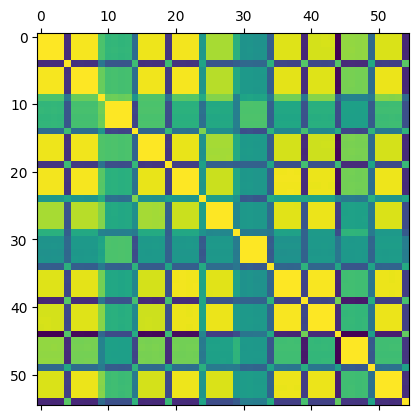

In [10]:
plt.matshow(data.corr())

In [12]:
def plot_corr(df,size=40):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)

    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);

C:\Users\lukiu\AppData\Local\Temp\ipykernel_26280\582990561.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


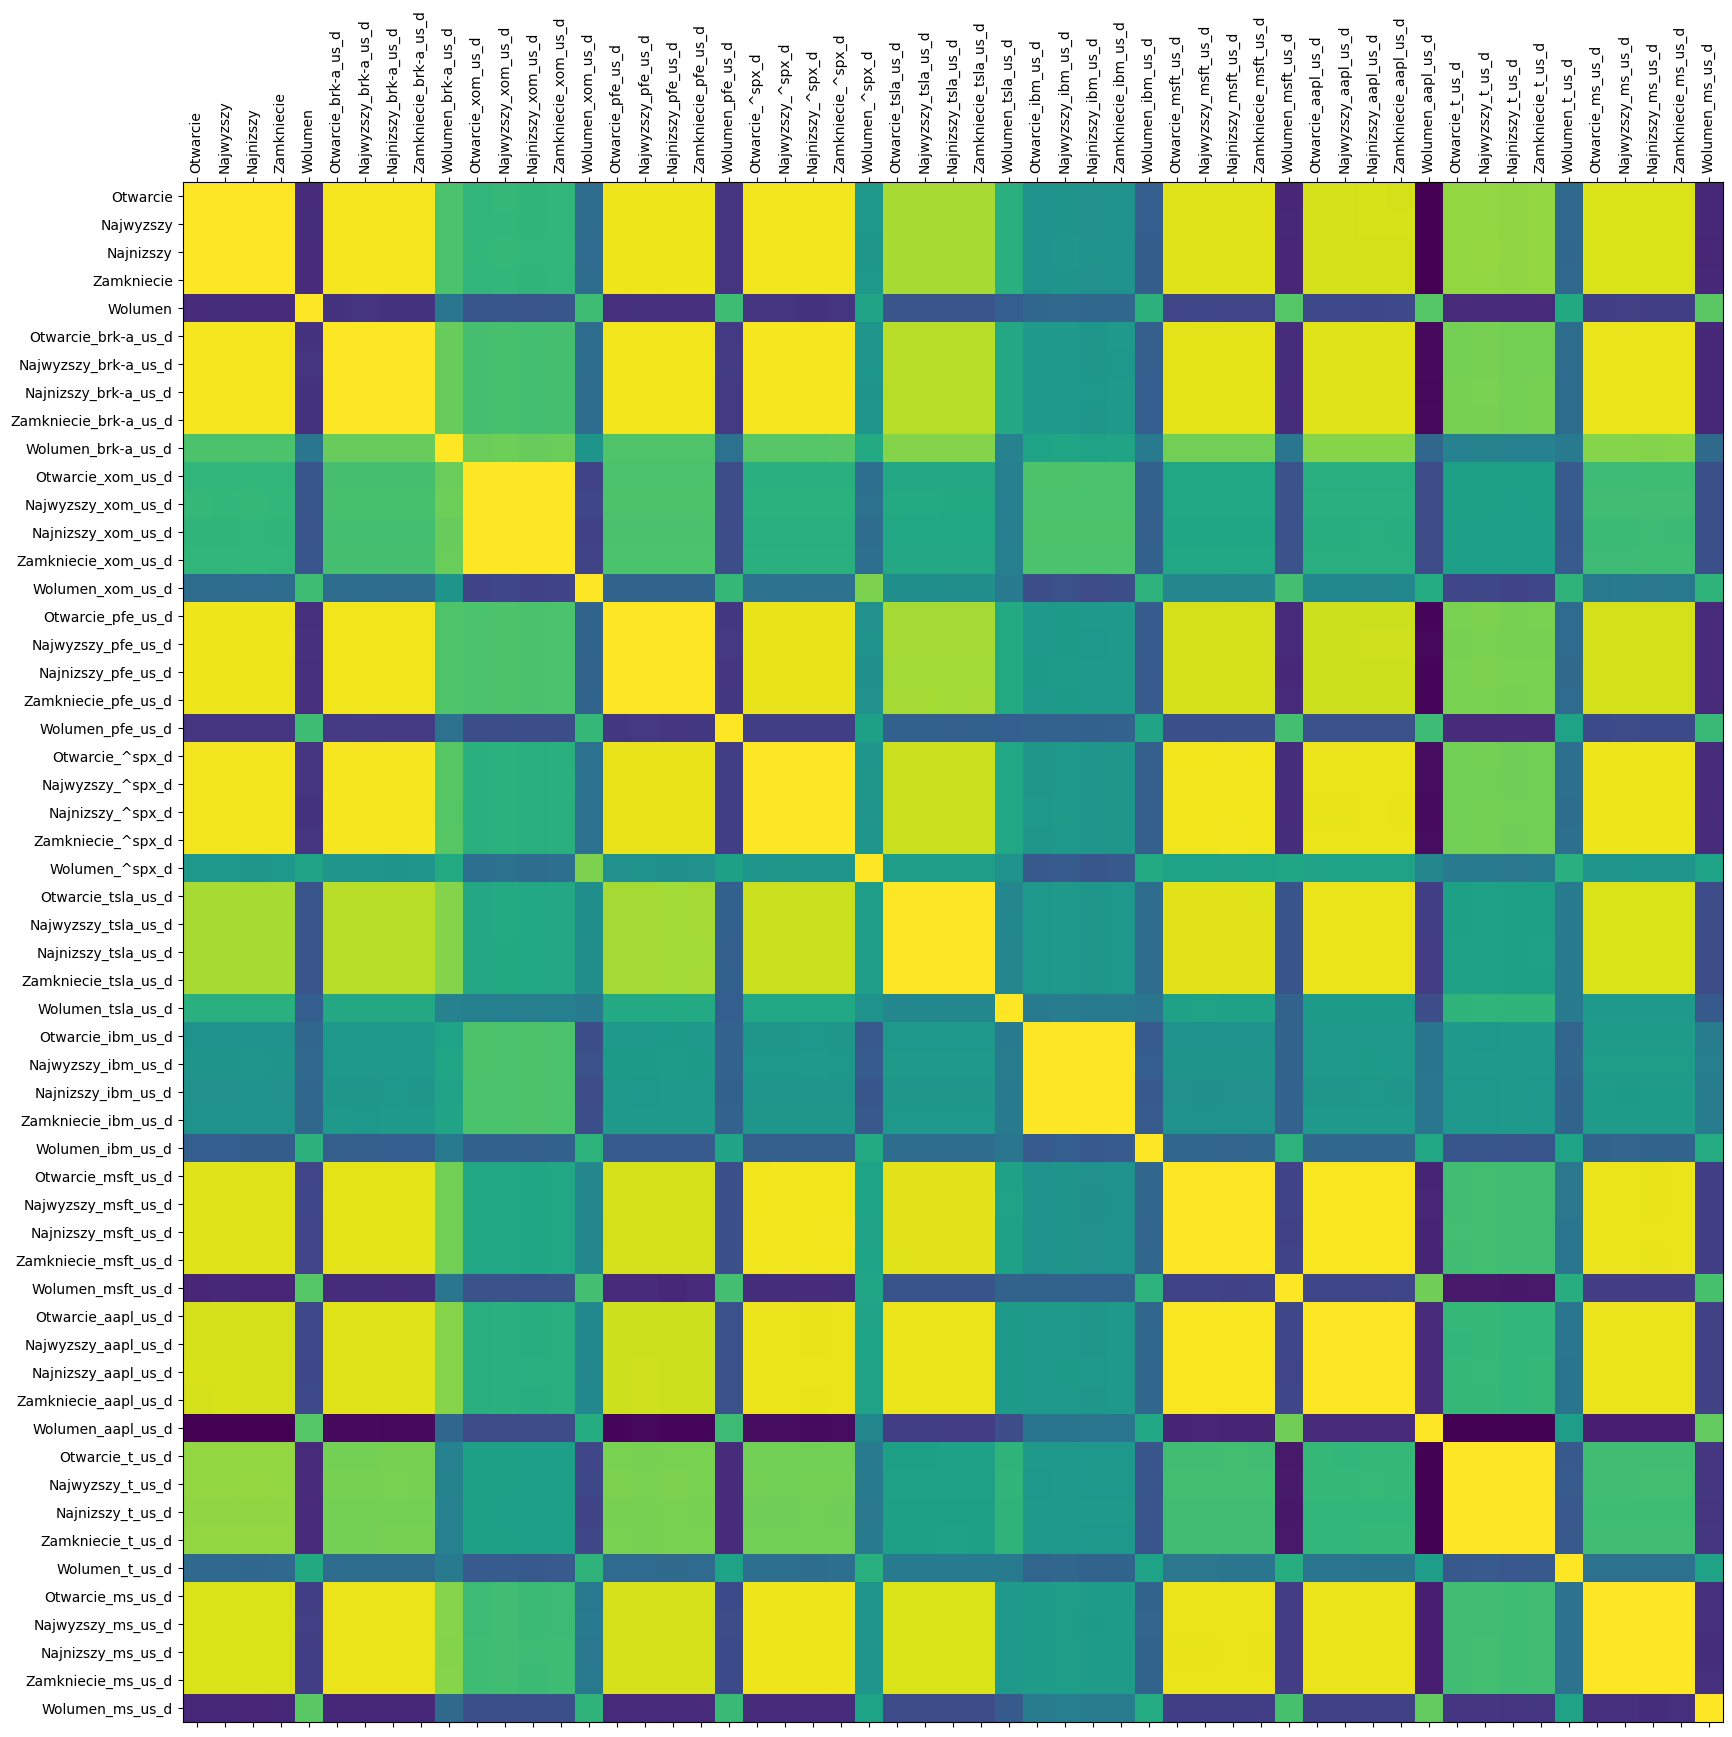

In [13]:
plot_corr(data,20)

In [15]:
corr = data.corr()
corr.style.background_gradient(cmap='bone')

C:\Users\lukiu\AppData\Local\Temp\ipykernel_26280\2506045228.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_brk-a_us_d,Najwyzszy_brk-a_us_d,Najnizszy_brk-a_us_d,Zamkniecie_brk-a_us_d,Wolumen_brk-a_us_d,Otwarcie_xom_us_d,Najwyzszy_xom_us_d,Najnizszy_xom_us_d,Zamkniecie_xom_us_d,Wolumen_xom_us_d,Otwarcie_pfe_us_d,Najwyzszy_pfe_us_d,Najnizszy_pfe_us_d,Zamkniecie_pfe_us_d,Wolumen_pfe_us_d,Otwarcie_^spx_d,Najwyzszy_^spx_d,Najnizszy_^spx_d,Zamkniecie_^spx_d,Wolumen_^spx_d,Otwarcie_tsla_us_d,Najwyzszy_tsla_us_d,Najnizszy_tsla_us_d,Zamkniecie_tsla_us_d,Wolumen_tsla_us_d,Otwarcie_ibm_us_d,Najwyzszy_ibm_us_d,Najnizszy_ibm_us_d,Zamkniecie_ibm_us_d,Wolumen_ibm_us_d,Otwarcie_msft_us_d,Najwyzszy_msft_us_d,Najnizszy_msft_us_d,Zamkniecie_msft_us_d,Wolumen_msft_us_d,Otwarcie_aapl_us_d,Najwyzszy_aapl_us_d,Najnizszy_aapl_us_d,Zamkniecie_aapl_us_d,Wolumen_aapl_us_d,Otwarcie_t_us_d,Najwyzszy_t_us_d,Najnizszy_t_us_d,Zamkniecie_t_us_d,Wolumen_t_us_d,Otwarcie_ms_us_d,Najwyzszy_ms_us_d,Najnizszy_ms_us_d,Zamkniecie_ms_us_d,Wolumen_ms_us_d
Otwarcie,1.000000,0.999846,0.999787,0.999232,-0.494067,0.975508,0.975466,0.975761,0.975560,0.514680,0.417343,0.425168,0.409513,0.416445,-0.109871,0.958249,0.957412,0.958506,0.957680,-0.450736,0.971501,0.971748,0.971115,0.971375,0.198562,0.773275,0.773345,0.773349,0.773388,0.374342,0.166753,0.174080,0.155991,0.164105,-0.203216,0.915436,0.915400,0.915484,0.915394,-0.528761,0.892632,0.892439,0.892990,0.892668,-0.712873,0.720553,0.724997,0.715749,0.719478,-0.129282,0.905134,0.905465,0.905107,0.905228,-0.524538
Najwyzszy,0.999846,1.000000,0.999734,0.999405,-0.490692,0.975402,0.975466,0.975648,0.975552,0.515264,0.415585,0.423547,0.407688,0.414762,-0.105795,0.958008,0.957370,0.958313,0.957644,-0.449208,0.971247,0.971594,0.970827,0.971189,0.203104,0.773392,0.773453,0.773415,0.773473,0.376113,0.164247,0.171970,0.153468,0.161927,-0.200595,0.915730,0.915759,0.915758,0.915728,-0.526411,0.892806,0.892659,0.893149,0.892872,-0.712021,0.719828,0.724528,0.715032,0.718978,-0.126907,0.904582,0.904982,0.904521,0.904719,-0.522481
Najnizszy,0.999787,0.999734,1.000000,0.999388,-0.499435,0.975549,0.975497,0.975925,0.975710,0.513649,0.418942,0.426687,0.411322,0.418149,-0.114929,0.958222,0.957454,0.958734,0.957897,-0.452616,0.971653,0.971890,0.971426,0.971650,0.192893,0.773470,0.773493,0.773569,0.773585,0.372324,0.169081,0.176423,0.158770,0.166818,-0.206129,0.915002,0.914945,0.915132,0.915019,-0.531717,0.892418,0.892205,0.892851,0.892506,-0.714231,0.721268,0.725625,0.716780,0.720392,-0.132219,0.905537,0.905806,0.905592,0.905661,-0.526987
Zamkniecie,0.999232,0.999405,0.999388,1.000000,-0.496547,0.975101,0.975177,0.975442,0.975387,0.513843,0.415757,0.423714,0.408037,0.415137,-0.110932,0.957728,0.957134,0.958214,0.957608,-0.451455,0.971126,0.971472,0.970843,0.971235,0.196592,0.773311,0.773403,0.773375,0.773491,0.375163,0.165156,0.172902,0.154733,0.163304,-0.209079,0.915138,0.915180,0.915255,0.915259,-0.530062,0.892388,0.892243,0.892809,0.892563,-0.713424,0.720248,0.724915,0.715699,0.719636,-0.128961,0.904477,0.904835,0.904485,0.904693,-0.525031
Wolumen,-0.494067,-0.490692,-0.499435,-0.496547,1.000000,-0.459901,-0.457829,-0.463206,-0.460798,-0.043215,-0.255579,-0.253835,-0.259214,-0.256423,0.470596,-0.474831,-0.471291,-0.479357,-0.475490,0.467244,-0.456943,-0.454778,-0.461151,-0.458402,0.284045,-0.262270,-0.261660,-0.263570,-0.262837,-0.204985,-0.133674,-0.128984,-0.140792,-0.135497,0.384828,-0.353575,-0.352285,-0.355343,-0.354017,0.550337,-0.338216,-0.337164,-0.339787,-0.338703,0.546498,-0.501040,-0.496847,-0.504701,-0.500223,0.327421,-0.392970,-0.390754,-0.396099,-0.393668,0.560473
Otwarcie_brk-a_us_d,0.975508,0.975402,0.975549,0.975101,-0.459901,1.000000,0.999852,0.999826,0.999684,0.602614,0.493699,0.501520,0.486192,0.493113,-0.098643,0.963311,0.963118,0.963589,0.963166,-0.420381,0.978825,0.979116,0.978281,0.978571,0.178746,0.814687,0.814764,0.814670,0.814650,0.318813,0.206575,0.213741,0.196187,0.204244,-0.198517,0.929713,0.929598,0.929680,0.929531,-0.492067,0.916989,0.916684,0.917508,0.917011

In [16]:
corr.to_csv('correlations.csv')

In [17]:
X = data[['Najnizszy_lpp_d', 'Najnizszy_pkn_d', 'Najwyzszy_sfs_d_Sfinks', 'Wolumen_kgh_d']]
for i in range (0, len(X.columns)):
    for j in range (0, len(X.columns)):
        if i!=j: 
            corr_1=np.abs(X[X.columns[i]].corr(X[X.columns[j]]))
            if corr_1 <0.3:
                print(X.columns[i], "is not correlated with", X.columns[j])
            elif corr_1 >0.6:
                print(X.columns[i], "is highly correlated with", X.columns[j])  

KeyError: "None of [Index(['Najnizszy_lpp_d', 'Najnizszy_pkn_d', 'Najwyzszy_sfs_d_Sfinks',\n       'Wolumen_kgh_d'],\n      dtype='object')] are in the [columns]"

In [59]:
corr = X.corr()
corr.style.background_gradient(cmap='bone')
corr.to_csv('correlations-filter.csv')

C:\Users\karolina\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<AxesSubplot:>

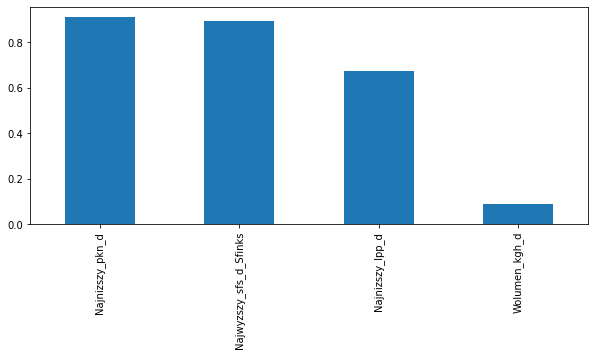

In [69]:
mi = mutual_info_regression(X, data[['Zamkniecie']])
mi = pd.Series(mi)
mi.index = X.columns
mi.sort_values(ascending = False)
mi.sort_values(ascending = False).plot.bar(figsize=(10,4))

In [210]:
from sklearn.preprocessing import MinMaxScaler

class BatchedData():
    from sklearn.preprocessing import MinMaxScaler

    def __init__(self,data,num_days,scaler=MinMaxScaler()):
        self.scaler = scaler
        self.data = data
        self.num_days = num_days
        
        #ogólnie zmienne z literą "X" dotyczą zbioru wejściowego, natomiast z literą "Y" dotyczą zbioru wyjściowego
        
        self.X = self.scaler.fit_transform(self.data.drop(columns=['Data','Zamkniecie']))#normalizacja danych i usunięcie kolumn, które nie mają być danymi wejściowymi
        self.y = self.data['Zamkniecie'].values/np.max(self.data['Zamkniecie'])#wartość kolumny "Zamknięcie" jest prognozowana na wyjściu sieci
        
        self.rng = np.random.randint(1,len(self.data)-self.num_days)#losowe wybieranie rekordów do zbiorów testowych i uczących
        self.x_batch = self.X[self.rng:self.rng+self.num_days,:]
        self.y_batch = self.y[self.rng-1]
        
    def nextBatch(self):
        rng = np.random.randint(1,len(self.data)-self.num_days)
        
        while(True):
            rng = np.random.randint(1,len(self.data)-self.num_days)
            
            if rng != self.rng:
                self.rng = rng
                break
                
        self.x_batch = self.X[self.rng:self.rng+self.num_days,:].reshape([self.num_days,self.X.shape[1]])
        self.y_batch = self.y[self.rng-1]
        
    def createDataset(self):
        train_range = int(len(self.data) * 0.67)# zbiór uczący
        test_range = int(len(self.data) * 0.33)#zbiór testowy
        
        self.X_train = np.zeros([train_range,num_days,self.X.shape[1]])
        self.Y_train = np.zeros([train_range])

        for i in range(train_range):
            self.nextBatch()
            self.X_train[i,:,:] = self.x_batch
            self.Y_train[i] = self.y_batch

        self.X_test = np.zeros([test_range,num_days,self.X.shape[1]])
        self.Y_test = np.zeros([test_range])

        for i in range(test_range):
            self.nextBatch()
            self.X_test[i,:,:] = self.x_batch
            self.Y_test[i] = self.y_batch

In [211]:
 print(len(data))

1081


In [221]:
num_days = 7 #liczba dni historycznych
batched_data = BatchedData(data,num_days)
batched_data.createDataset()#utworzony jest zbiór z danymi historycznymi

#len(np.unique(batched_data.X_train))
print("Dane wyjściowe testowe:",len(np.unique(batched_data.Y_train)))

Dane wyjściowe testowe: 486


In [213]:
data_size = int(batched_data.x_batch.shape[1])
#print(data_size)
#tworzenie modelu
model = Sequential()

model.add(LSTM(units=77,activation='relu',input_shape=[num_days,data_size],return_sequences=True))
#tworzenie warstwy LSTM, podajemy liczbę neuronow, rodzaj funkcji aktywacji, liczbę historycznych notowań, rozmiar danych, zwracana jest sekwencja danych taka, jaka jest liczba historycznych notowań
#model.add(LSTM(units=100,activation='relu',return_sequences=True))
#model.add(LSTM(units=74,activation='relu',return_sequences=True))
model.add(Dropout(rate=0.5))

#model.add(LSTM(units=56,activation='softmax',return_sequences=True))
#model.add(LSTM(units=42,activation='softmax',return_sequences=True))
model.add(LSTM(units=37,activation='softmax',return_sequences=True))
model.add(Dropout(rate=0.5))

model.add(LSTM(units=24,activation='relu',return_sequences=True))
model.add(LSTM(units=12,activation='relu',return_sequences=True))
model.add(Dropout(rate=0.3))

model.add(LSTM(units=6,activation='sigmoid',return_sequences=True))
model.add(Flatten())
model.add(Dense(units=1,activation='sigmoid'))


In [214]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])#kompilacja modelu, funkcja oceny i metryka to błąd średniokwadratowy

In [215]:
epochs = 60 #liczba epok uczących
batch=32
#uczenie modelu, podajemy jako parametry dane ze zbioru uczącego (wejście i wyjćie) i dane ze zbioru testowego (wejście i wyjćie)

history = model.fit(batched_data.X_train,batched_data.Y_train,
                    validation_data=(batched_data.X_test,batched_data.Y_test),
                    epochs=epochs,
                    batch_size=batch)

Epoch 1/60
23/23 [==============================] - 9s 121ms/step - loss: 0.1543 - mse: 0.1543 - val_loss: 0.1204 - val_mse: 0.1204
Epoch 2/60
23/23 [==============================] - 1s 25ms/step - loss: 0.0935 - mse: 0.0935 - val_loss: 0.0668 - val_mse: 0.0668
Epoch 3/60
23/23 [==============================] - 1s 26ms/step - loss: 0.0435 - mse: 0.0435 - val_loss: 0.0210 - val_mse: 0.0210
Epoch 4/60
23/23 [==============================] - 1s 26ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 5/60
23/23 [==============================] - 1s 26ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0173 - val_mse: 0.0173
Epoch 6/60
23/23 [==============================] - 1s 26ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 7/60
23/23 [==============================] - 1s 26ms/step - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 8/60
23/23 [==============================] - 1s 25ms/step - loss: 0.0148 - 

23/23 [==============================] - 1s 29ms/step - loss: 7.2049e-04 - mse: 7.2049e-04 - val_loss: 4.4965e-04 - val_mse: 4.4965e-04


In [216]:
print(history.history['val_loss'])

[0.1203581690788269, 0.06682568788528442, 0.02104111947119236, 0.018051274120807648, 0.0173010416328907, 0.016505608335137367, 0.014632578939199448, 0.01181272603571415, 0.008972946554422379, 0.005980335641652346, 0.004036974627524614, 0.0033403499983251095, 0.003240260761231184, 0.0032081352546811104, 0.0034600694198161364, 0.003243735060095787, 0.002913534641265869, 0.002671764465048909, 0.0023775151930749416, 0.00203153258189559, 0.001704203081317246, 0.0014314346481114626, 0.0017597893020138144, 0.001167737296782434, 0.0012318362714722753, 0.0011533176293596625, 0.0008674109121784568, 0.000730732164811343, 0.0009223654051311314, 0.0007416313164867461, 0.0011632705572992563, 0.0007079191855154932, 0.0005761941429227591, 0.0007104235119186342, 0.0006772812339477241, 0.000583043263759464, 0.0006956515717320144, 0.0007251594215631485, 0.0006403442239388824, 0.0006859246641397476, 0.0005999879213050008, 0.0005216572899371386, 0.00046261530951596797, 0.0005003950791433454, 0.000594651268

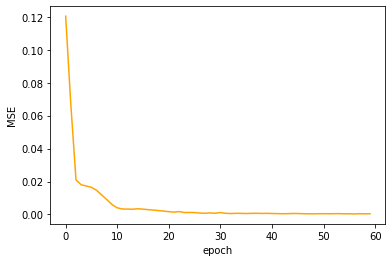

In [217]:
plt.plot(history.history['val_loss'],color='orange')#wykres procesu uczenia się - wyniki danych testowych
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

In [218]:
Y_pred=model.predict(batched_data.X_test)#dokonujemy predykcji z wykorzystaniem nauczonego modelu


In [219]:
for i in range(len(batched_data.Y_test)):
            print(Y_pred[i,0],'\t',batched_data.Y_test[i]) #wyświetlenie wartości prognozowanych i faktycznych


0.93093514 	 0.92812216901773
0.88493437 	 0.8656917302963634
0.72584546 	 0.7348518182994694
0.8983456 	 0.862792804451922
0.935309 	 0.9524524394978647
0.5175614 	 0.5169664811699236
0.81584895 	 0.8129416332341142
0.70863676 	 0.7077261550407662
0.78289616 	 0.7910443898019931
0.9271914 	 0.9600362365730556
0.8723283 	 0.8667270609550926
0.5306956 	 0.5954963116345283
0.94083333 	 0.9677235667141193
0.6995714 	 0.6915491134981235
0.6681742 	 0.6690565549372331
0.85949636 	 0.8477805099003494
0.6729288 	 0.6787627798628187
0.92613316 	 0.8905137828393944
0.708176 	 0.688650187653682
0.90246177 	 0.8922738449592339
0.68431187 	 0.6875372071955481
0.94011045 	 0.9643846253397179
0.69098514 	 0.6971398990552609
0.7434161 	 0.75894913938139
0.6651877 	 0.6512488676070921
0.7010586 	 0.7177947456969069
0.9231186 	 0.8963375177947458
0.7344147 	 0.7284327682153489
0.92015713 	 0.8860100944739226
0.72050333 	 0.7167076485052414
0.9233483 	 0.9517535913032226
0.65852994 	 0.6630775203830723
